# Notes of Convolutional Neural Network

By: Haiyang Yu, 10/27/2017, yhyoscar@gmail.com

Contents:

1. Conventional/artificial neural network
2. Convolution layer
3. Pooling layer
4. Dropout

# 1. Artificial neural network

As shown in our previous notes, the conventional neural networks are fully connected: every nodes in the previous layer is connected with the nodes in the next layer. This causes too much computational time and memories. Besides, the features of images usually are captured locally, so we do not necessary need to use a fully convected network.

The ways to solve this problem are convolution and pooling.

http://cs231n.github.io/convolutional-networks/

# 2. Convolution layer

The function of convolution is capturing the local features in the image and reducing the complexities of the network.

Convolution:

$$ (f*g)(t) = \int_{-\infty}^{\infty} f(\tau) g(t-\tau) d\tau = \int_{-\infty}^{\infty} f(t-\tau) g(\tau) d\tau $$

Notice that the two functions f and g are symmetric (commutativity) in the equation: $f*g = g*f$;

Associativity: $f*(g*h) = (f*g)*h$

Distributivity: $f*(g+h) = f*g + f*h$

Delta function: $f * \delta = f$

Differentiation and integration: https://en.wikipedia.org/wiki/Convolution

Convolution theorem:

$$ \mathcal{F} (f*g) = \mathcal{F}(f) \cdot \mathcal{F}(g) $$

For large scale data, the convolution algrithm proformed via FFT is faster than the direct way.

In [1]:
import numpy as np
from scipy import signal
from time import time as timer
sig = np.random.randn(100000)

t0 = timer()
ac  = signal.convolve(sig, sig[::-1], method='direct')
print timer()-t0

t0=timer()
ac  = signal.convolve(sig, sig[::-1], method='fft')
print timer()-t0


5.84355998039
0.0703959465027


In [8]:
x = np.linspace(0,1,10) # n
conv = np.array([-1,1,2,2,-1]) # l
# n - (l - 1)
y2 = signal.convolve(x, conv, mode='valid')
# n + (l - 1)
#y2 = signal.convolve(x, conv, mode='full')
print y2, len(y2)

[ 0.55555556  0.88888889  1.22222222  1.55555556  1.88888889  2.22222222] 6


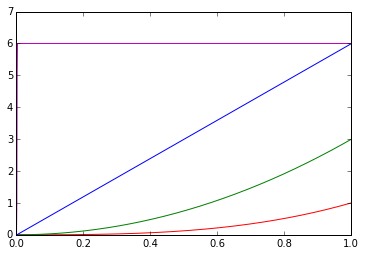

In [9]:
# convolution as differentiation

import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt

x = np.linspace(0,1,1000)
y = x**3
conv = np.array([-1,1])/(1*(x[1]-x[0]) )

cstrs = ['g','b','m']
plt.plot(x,y, 'r')
for i in range(3):
    y = signal.convolve(y, conv[::-1], mode='same')
    #y = signal.convolve(y, conv[::-1])
    plt.plot(x, y, cstrs[i])


[ 1 -2  1]


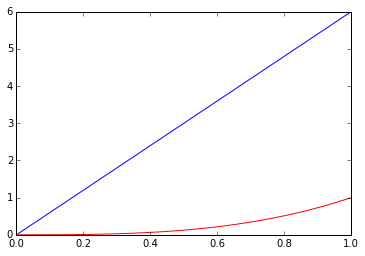

In [10]:
# 2-order differentiation: Laplace convolution
# e.g. 1-order differentiation: i ~ ( y(i+1) - y(i-1) ) / (x(i+1) - x(i-1))
#  2nd diff: i ~ { (( y(i+1) - y(i) ) / (x(i+1) - x(i))) - \ 
#    (( y(i) - y(i-1) ) / (x(i) - x(i-1)))  } / (x(i+1/2) - x(i-1/2))

print np.convolve([1,-1], [1,-1])

import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt

x = np.linspace(0,1,200)
y = x**3
conv = np.array([1,-2,1])/((x[1]-x[0])**2 )

plt.plot(x,y, 'r')
plt.plot(x[1:-1], signal.convolve(y, conv[::-1], mode='same')[1:-1], 'b')


## 2D convolution: image processing


### Edge detecting (e.g. Laplace), sharpen, blurring (e.g. average, Gaussian), unsharp masking

https://en.wikipedia.org/wiki/Kernel_(image_processing)

https://docs.gimp.org/en/plug-in-convmatrix.html


(300, 300, 3)


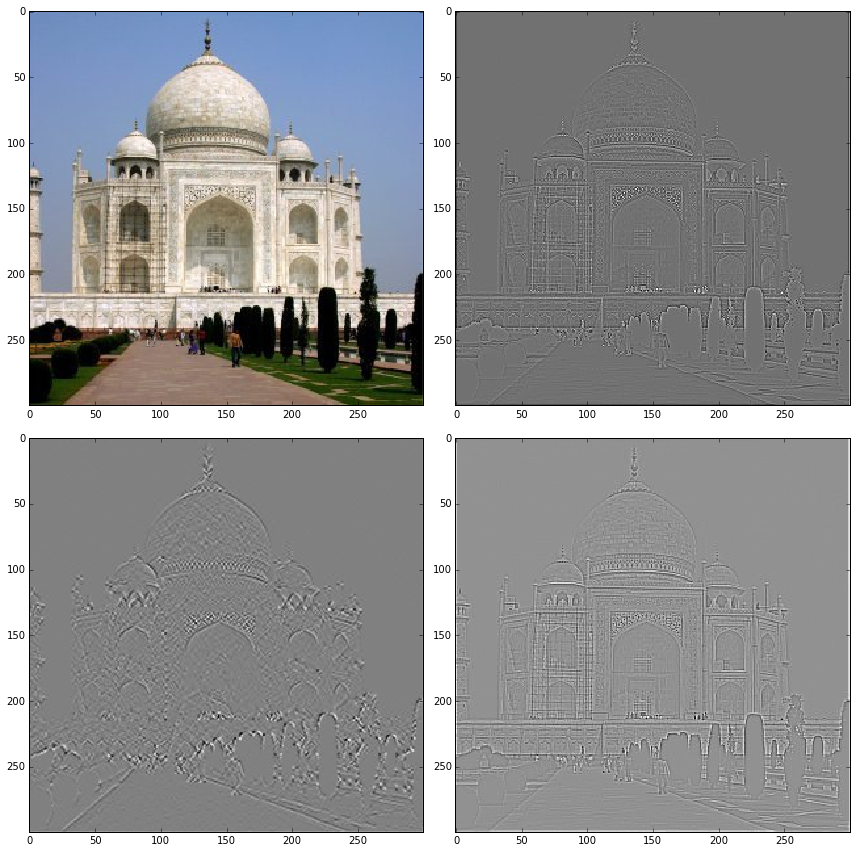

In [11]:
# edge detecting

import matplotlib.image as mpimg

pic = mpimg.imread('taj_orig.jpg')
print pic.shape

fts = np.array([ [[0, 1, 0], \
                  [1, -4, 1], \
                  [0, 1, 0]], \
                 [[1, 0, -1], \
                  [0, 0, 0], \
                  [-1, 0, 1]], \
                 [[-1, -1, -1], \
                  [-1, 8, -1], \
                  [-1, -1, -1]]  ])

plt.figure(1, figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(pic, interpolation='None')

for k in range(3):
    plt.subplot(2,2,k+2)
    plt.imshow(signal.convolve2d(np.mean(pic, axis=2), fts[k], mode='same'), \
               cmap='gray', interpolation='None' )

plt.tight_layout()

In [12]:
# edge detecting, sharpen, blurring

import tensorflow as tf
import matplotlib.image as mpimg

sess = tf.Session()
sess.run(tf.global_variables_initializer())


(1, 300, 300, 1)
(3, 3, 1, 3)


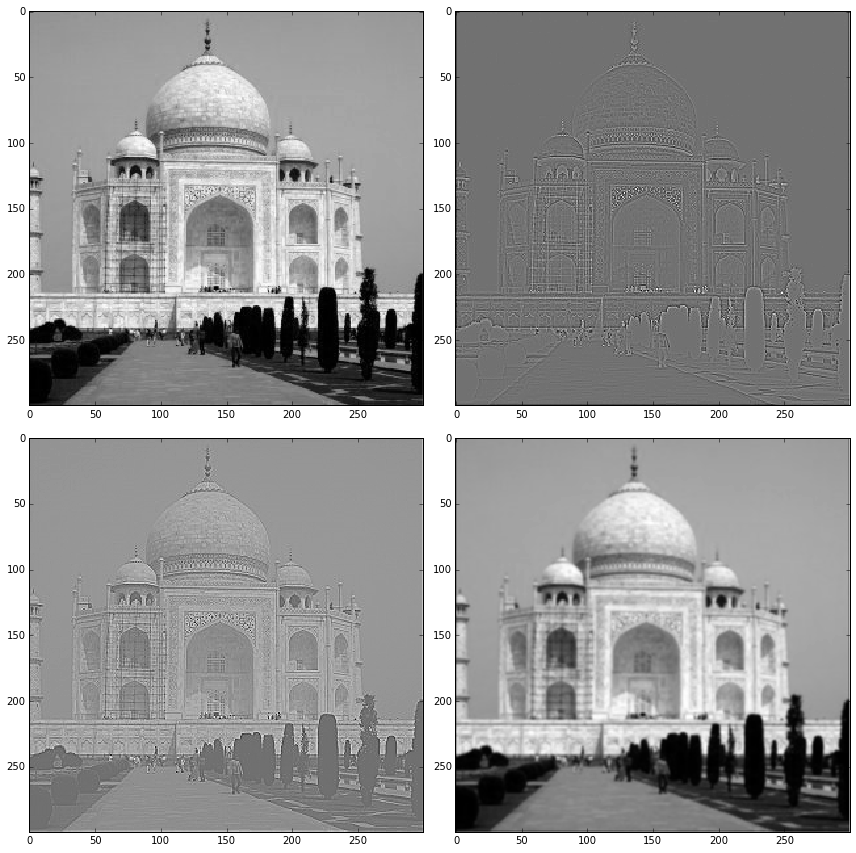

In [13]:
pic = tf.constant(np.mean(mpimg.imread('taj_orig.jpg'), axis=2).reshape(1,300,300,1), \
                  dtype=tf.float32)
print sess.run(pic).shape

f = np.zeros([3,3,1,3])
f[:, :,0,0] = np.array([[0,1,0], \
               [1,-4,1], \
               [0,1,0]] )
f[:, :,0,1] = np.array([[0,-1,0], \
               [-1,5,-1], \
               [0,-1,0]])
f[:, :,0,2] = np.array([[1,2,1], \
               [2,4,2], \
               [1,2,1]])/16.0

fts = tf.constant(f, dtype=tf.float32)
print sess.run(fts).shape

conv = tf.nn.conv2d(pic, fts, strides=[1,1,1,1], padding='SAME')
pic2 = sess.run(conv).reshape(300,300,3)

plt.figure(1, figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(sess.run(pic).reshape(300,300), interpolation='none', cmap='gray')
for k in range(3):
    plt.subplot(2,2,k+2)
    plt.imshow(pic2[:,:,k], interpolation='none', cmap='gray' )

plt.tight_layout()

In [14]:
relu = tf.nn.relu(conv)
print sess.run(relu).shape

(1, 300, 300, 3)


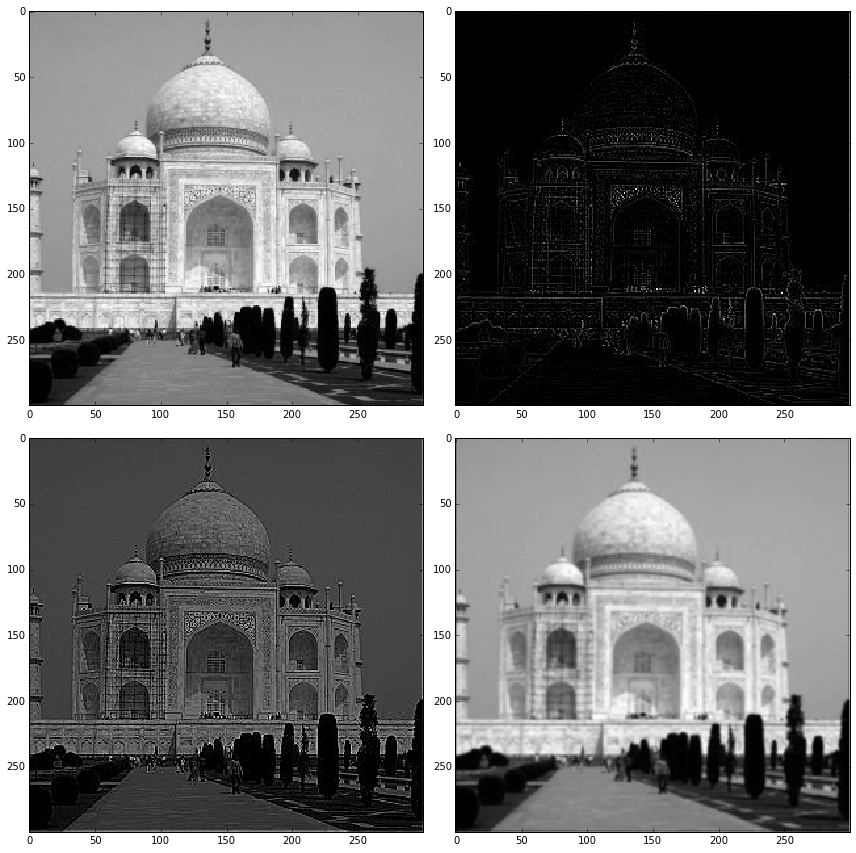

In [15]:
pic2 = sess.run(relu).reshape(300,300,3)

plt.figure(1, figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(sess.run(pic).reshape(300,300), interpolation='none', cmap='gray')
for k in range(3):
    plt.subplot(2,2,k+2)
    plt.imshow(pic2[:,:,k], interpolation='none', cmap='gray' )
plt.tight_layout()


## 3. Pooling layer

The purpose of pooling layer is downscaling the resolution of the images.

e.g. Averaging pooling, maximum pooling


In [16]:
pavg = tf.nn.avg_pool(relu, ksize=[1, 2, 2, 1], \
                      strides=[1, 2, 2, 1], padding='SAME')
pmax = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], \
                      strides=[1, 2, 2, 1], padding='SAME')
print sess.run(pavg).shape, sess.run(pmax).shape

(1, 150, 150, 3) (1, 150, 150, 3)


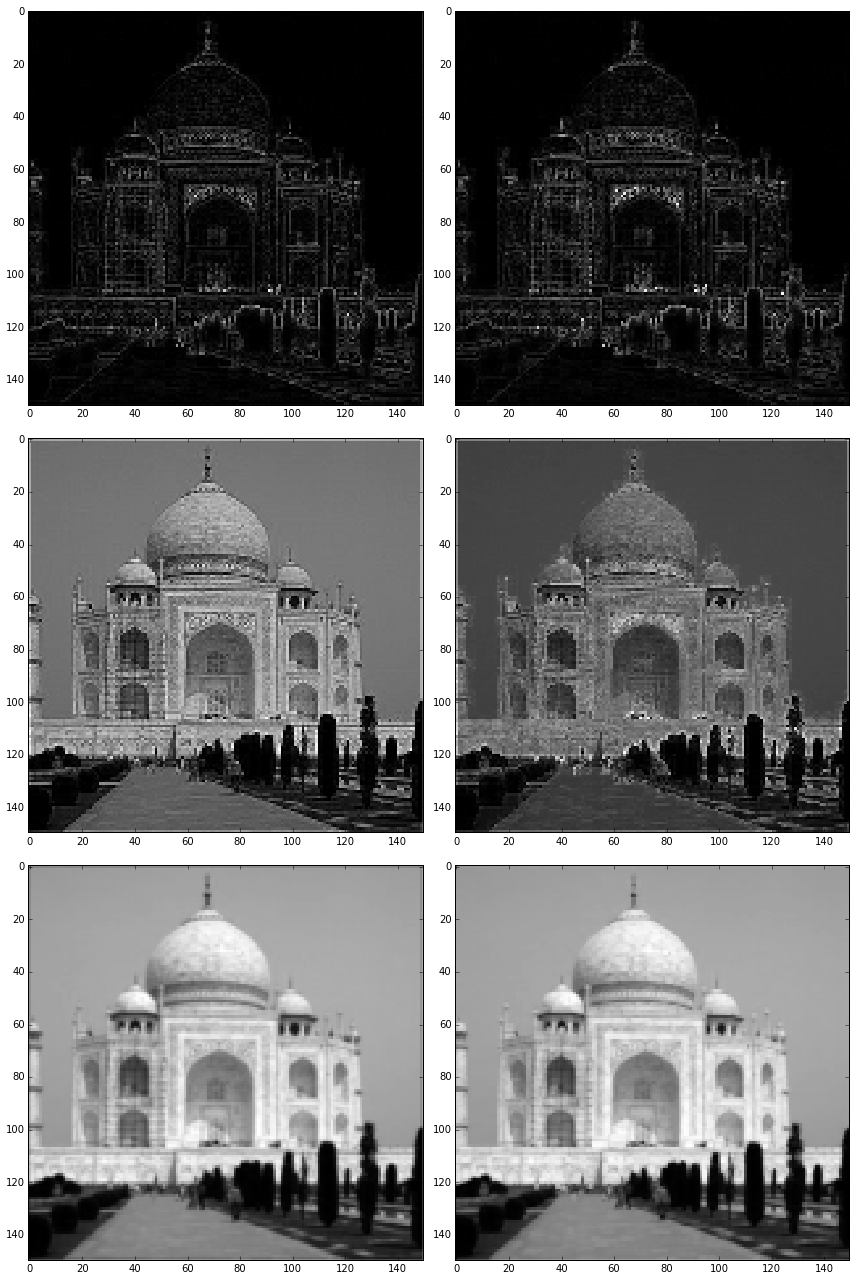

In [17]:
plt.figure(1, figsize=(12,18))
for j in range(2):
    if j==0: pic2 = sess.run(pavg).reshape(150,150,3)
    if j==1: pic2 = sess.run(pmax).reshape(150,150,3)
    for i in range(3):
        plt.subplot(3,2,i*2+j+1)
        plt.imshow(pic2[:,:,i], interpolation='none', cmap='gray' )
        plt.tight_layout()


In [18]:
ft3d = tf.constant(f.reshape(3,3,3,1), dtype=tf.float32 )
conv2 = tf.nn.conv2d(pmax, ft3d, strides=[1,1,1,1], padding='SAME')
relu2 = tf.nn.relu(conv2)
print sess.run(conv2).shape, sess.run(relu2).shape

# d2y/dx2 ~ -y; local features


(1, 150, 150, 1) (1, 150, 150, 1)


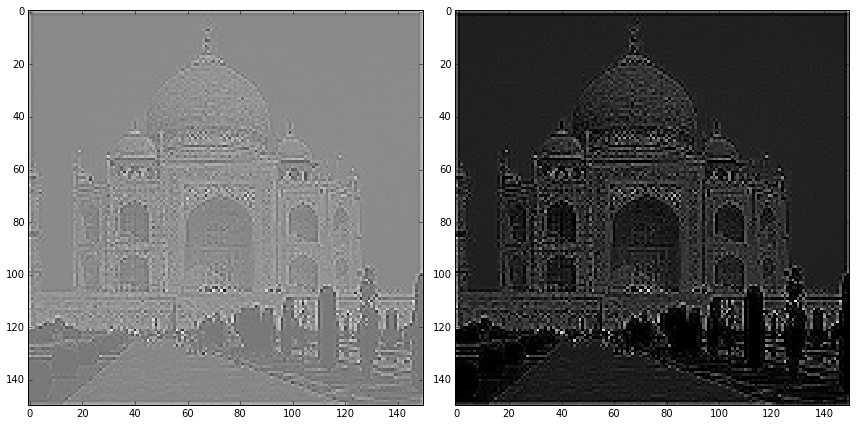

In [19]:
plt.figure(1, figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(sess.run(conv2).reshape(150,150), interpolation='none', cmap='gray' )
plt.subplot(1,2,2)
plt.imshow(sess.run(relu2).reshape(150,150), interpolation='none', cmap='gray' )
plt.tight_layout()


## 4. Dropout

When there are too many nodes in the neural network, dropout is needed to prevent the overfitting and decrease the time cost of comuputation.

Srivastava et al., 2014: Dropout: A Simple Way to Prevent Neural Networks from Overfitting. Journal of Machine Learning Research.

In [42]:
pflat = tf.reshape(relu2, [1, 150*150])
pdrop = tf.nn.dropout(pflat, keep_prob=.2)

In [43]:
print sess.run(pflat)[0,0:10]
print sess.run(pdrop)[0,0:10]

[ 1742.68469238   685.27624512   862.96624756   850.05218506   859.09906006
   853.14593506   856.91796875   837.77868652   891.51678467   869.49987793]
[    0.             0.             0.             0.          4295.49511719
  4265.72949219     0.             0.             0.             0.        ]


In [279]:
# The sizes of the layer and weight are the same as before, 
# but the values of some nodes will not be updated in the further iterations.
print sess.run(pflat).shape
print sess.run(pdrop).shape

(1, 22500)
(1, 22500)
